# Setup

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys
sys.path.append("../scripts/")
from helper import *

In [2]:
GRAY4 = '#646369'
GRAY5 = '#76787B'
GENDER_0 = '#59AB61'
GENDER_1 = '#3791AB'
ABOVE65_0 = '#74F782'
ABOVE65_1 = '#5CD5F7'
ICU_0 = '#ADA476'
ICU_1 = '#FF4336'

# Load Data

In [3]:
path_dados = '../raw_data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
dados = pd.read_excel(path_dados)
dados["PATIENT_VISIT_IDENTIFIER"] = dados["PATIENT_VISIT_IDENTIFIER"].astype("category")
dados["AGE_ABOVE65"] = dados["AGE_ABOVE65"].astype("category")
dados["AGE_PERCENTIL"] = dados["AGE_PERCENTIL"].astype("category")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


# Exploratory Data Analysis

Os dados são divididos em 4 grupos:
* Informação demográfica - 3 variáveis
* Doenças pré-existentes - 9 variáveis
* Resultados do exame de sangue - 36 variáveis
* Sinais vitais - 6 variáveis

Cada linha dos dados representa um paciente em uma janela de tempo (Coluna `WINDOW`) e como resultado, temos que o paciênte foi ou não transferido para UTI. (Coluna `ICU`).

## Informações demográficas

Pegando apenas a primeira linha por paciente, dado que esses dados são invariáveis a cada hora

In [4]:
def prepare_window(rows):
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW']=='0-2', 'ICU'] = 1
    return rows.loc[rows['WINDOW']=='0-2']

demographic_columns = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'ICU']
demographic_data = dados.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window).reset_index(drop=True)[demographic_columns]
demographic_data#.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,ICU
0,1,60th,0,1
1,1,90th,1,1
2,0,10th,0,1
3,0,40th,1,0
4,0,10th,0,0
...,...,...,...,...
380,0,40th,1,1
381,1,Above 90th,0,0
382,0,50th,0,1
383,0,40th,1,0


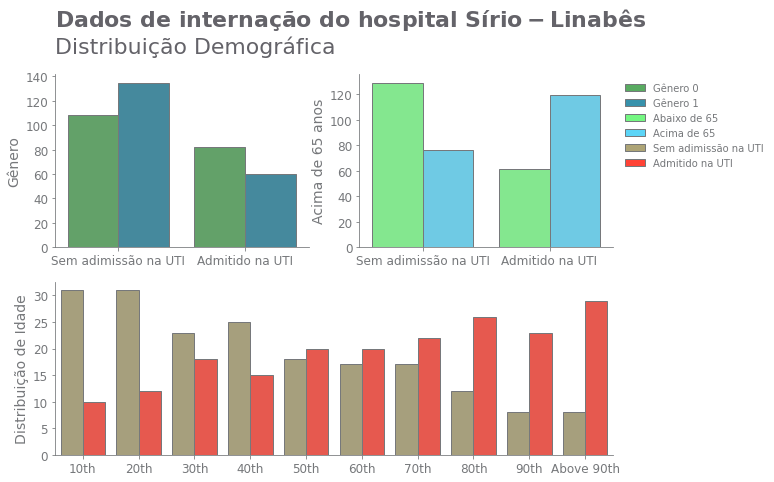

In [5]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 1, 2)
axis = [ax1, ax2, ax3]
g = sns.countplot(data=demographic_data, ax=ax1, x="GENDER", hue='ICU', palette=[GENDER_0, GENDER_1], edgecolor=GRAY5);
g = sns.countplot(data=demographic_data, ax=ax2, x="AGE_ABOVE65", hue='ICU', palette=[ABOVE65_0, ABOVE65_1], edgecolor=GRAY5);
g = sns.countplot(data=demographic_data, ax=ax3, x="AGE_PERCENTIL", hue='ICU', palette=[ICU_0, ICU_1], edgecolor=GRAY5);
xticks_g = ["Sem adimissão na UTI", "Admitido na UTI"]
ax1.set_xticklabels(xticks_g, fontsize=12)
ax2.set_xticklabels(xticks_g, fontsize=12)

suptitle = 'Dados de internação do hospital Sírio-Linabês'
subtitle = 'Distribuição Demográfica'
y_label = ['Gênero', 'Acima de 65 anos', 'Distribuição de Idade']
presentation(fig=fig, ax=axis, y_label=y_label, title=suptitle, subtitle=subtitle, grid=False)
sns.despine()

gen_0 = mpatches.Patch(facecolor=GENDER_0, edgecolor=GRAY5, label="Gênero 0")
gen_1 = mpatches.Patch(facecolor=GENDER_1, edgecolor=GRAY5, label="Gênero 1")
abv65_0 = mpatches.Patch(facecolor=ABOVE65_0, edgecolor=GRAY5, label="Abaixo de 65")
abv65_1 = mpatches.Patch(facecolor=ABOVE65_1, edgecolor=GRAY5, label="Acima de 65")
icu_0 = mpatches.Patch(facecolor=ICU_0, edgecolor=GRAY5, label="Sem adimissão na UTI")
icu_1 = mpatches.Patch(facecolor=ICU_1, edgecolor=GRAY5, label="Admitido na UTI")
plt.sca(ax2)
plt.legend(handles=[gen_0, gen_1, abv65_0, abv65_1, icu_0, icu_1], loc='upper right', bbox_to_anchor=(1.63, 1.0), frameon=False, labelcolor=GRAY5)
plt.show()

Pelo dados, vamos que dá uma discrepância grande entre os gêneros 0 e 1. Possívelmente temos como genêro 0 como masculino e 1 como feminino, visto que [REF] apontam como o gênero masculino sendo maissucetivel a infecção por COVID-19. Além disto, há uma clara diferença na admissão da UTI para o sexo masculino.

Embora os números entre acima de 65 anos e abaixo sejam semelhantes, vale notar que a população acima de 65 anos é muito menor em relação aos demais grupos etários. O que indica uma maior susceptibilidade dada a idade. 

A distribuição de idade também confirma essa hipótese.

Genero Ref:
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7271824/
* https://www.frontiersin.org/articles/10.3389/fpubh.2020.00152/full?fbclid=IwAR0j28d7CvO1w_CKJyFyyaE4PkjERGrRNZQe4TdNo_XmBSQ_H-8ZQM_pjZ4
* https://www.nature.com/articles/s41467-020-19741-6

## Doenças Pré-Existentes

In [6]:
def prepare_window(rows):
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW']=='0-2', 'ICU'] = 1
    return rows.loc[rows['WINDOW']=='0-2']

preexisting_disease_columns = ['PATIENT_VISIT_IDENTIFIER', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER', 'ICU']
preexisting_disease_data = dados.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window).reset_index(drop=True)[preexisting_disease_columns]#.reset_index()
preexisting_disease_data
# preexisting_disease_data_melt = preexisting_disease_data.melt(id_vars=['PATIENT_VISIT_IDENTIFIER', 'ICU'], value_vars=preexisting_disease_columns[:-1],
#         var_name='Doenças Pré-Existentes', value_name='value')
# preexisting_disease_data_melt

,PATIENT_VISIT_IDENTIFIER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ICU
0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
380,380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
381,381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
382,382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
383,383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


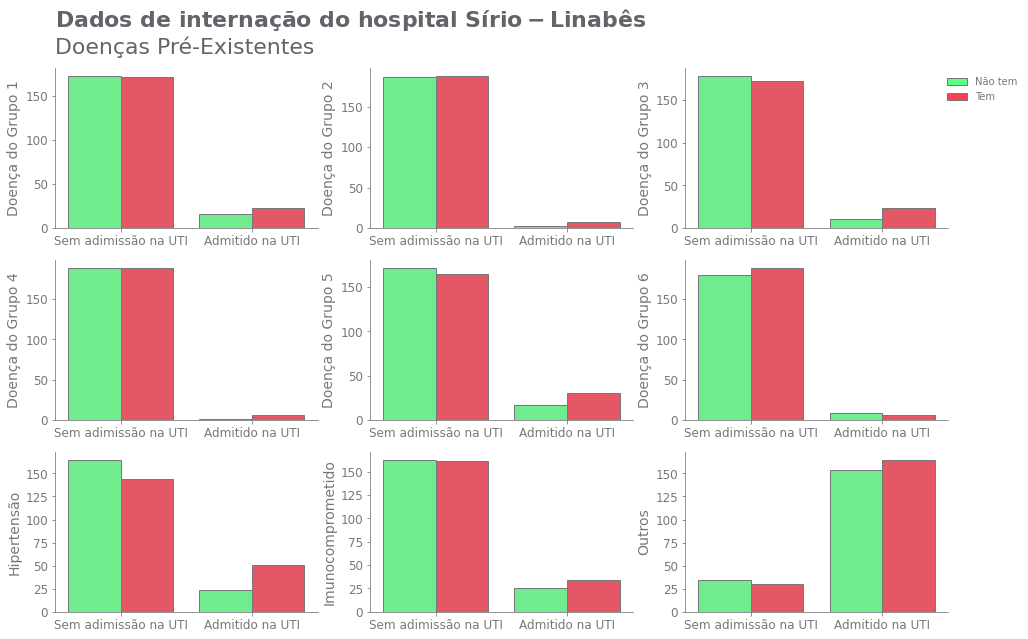

In [7]:
xticks_g = ["Sem adimissão na UTI", "Admitido na UTI"]
preexisting_disease_columns = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER']
preexisting_disease_labels = ['Doença do Grupo 1', 'Doença do Grupo 2', 'Doença do Grupo 3', 'Doença do Grupo 4', 'Doença do Grupo 5', 'Doença do Grupo 6', 'Hipertensão', 'Imunocomprometido', 'Outros']
suptitle = 'Dados de internação do hospital Sírio-Linabês'
subtitle = 'Doenças Pré-Existentes'
DISEASE_0 = '#5CFF82'
DISEASE_1 = '#FA4151'

fig, ((ax11, ax12, ax13),(ax21,ax22,ax23),(ax31,ax32,ax33)) = plt.subplots(nrows=3, ncols=3, figsize=(16, 10)) #(10, 6)
axes = [ax11, ax12, ax13,ax21,ax22,ax23,ax31,ax32,ax33]
for i, ax in enumerate(axes):
    sns.countplot(data=preexisting_disease_data, x=preexisting_disease_columns[i], hue='ICU',ax=ax, palette=[DISEASE_0, DISEASE_1], edgecolor=GRAY5)
    ax.set_xticklabels(xticks_g, fontsize=12)
presentation(fig=fig, ax=axes, y_label=preexisting_disease_labels, title=suptitle, subtitle=subtitle,
             title_position = 0.085, grid=False, legend=False)

disease_0 = mpatches.Patch(facecolor=DISEASE_0, edgecolor=GRAY5, label="Não tem")
disease_1 = mpatches.Patch(facecolor=DISEASE_1, edgecolor=GRAY5, label="Tem")
plt.sca(ax13)
plt.legend(handles=[disease_0, disease_1], loc='upper right', bbox_to_anchor=(1.3, 1.0), frameon=False, labelcolor=GRAY5)

sns.despine()

## Sinais Vitais

Temos 6 tipos de sinais:

* Pressão Arterial Diastólica (PAD)
* Pressão Arterial Sistólica (PAS)
* Frequência Cardiaca
* Saturação do Oxigênio
* Frequência Respiratória
* Temperatura

Deste dados, temos:

* Minimo
* Máximo
* Média
* Mediana
* Diferença
    * É a diferença entre os valores máximo e mínimo (`max - min`)
* Diferença Relativa
    * É o quociente entre diferença e mediana (`diff / median`)

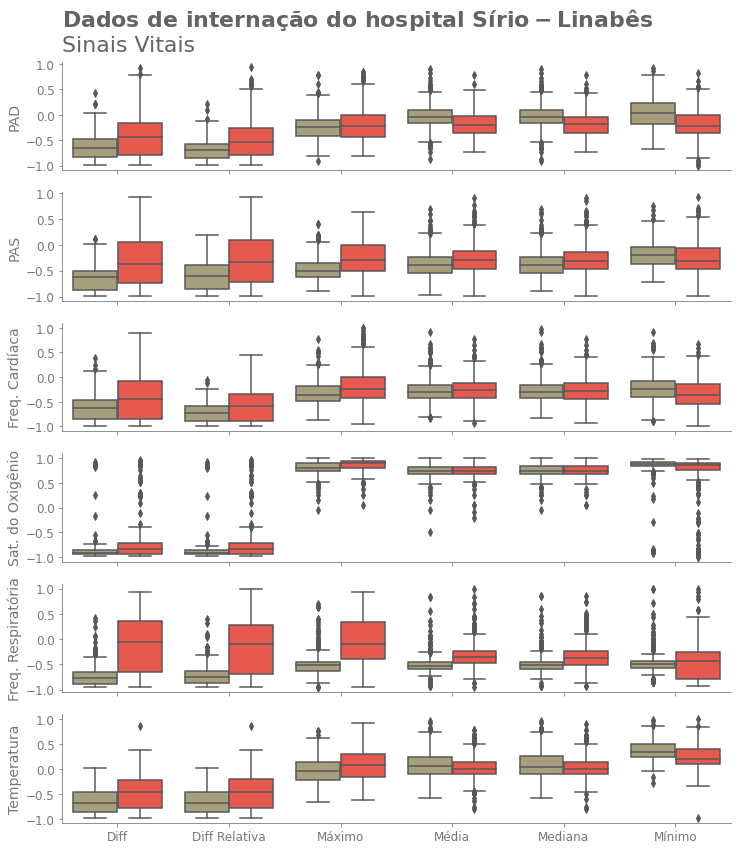

In [11]:
attributes_suffix = ['DIFF', 'DIFF_REL', 'MAX', 'MEAN', 'MEDIAN', 'MIN']
vital_signs = ['BLOODPRESSURE_DIASTOLIC', 'BLOODPRESSURE_SISTOLIC', 'HEART_RATE', 'OXYGEN_SATURATION', 'RESPIRATORY_RATE', 'TEMPERATURE']

attributes_label = ['Diff', 'Diff Relativa', 'Máximo', 'Média', 'Mediana', 'Mínimo']
vital_signs_label = ['PAD', 'PAS', 'Freq. Cardíaca', 'Sat. do Oxigênio', 'Freq. Respiratória', 'Temperatura']

suptitle = 'Dados de internação do hospital Sírio-Linabês'
subtitle = 'Sinais Vitais'

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(12, 14), sharex=True) #(10, 6)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for i, vital in enumerate(vital_signs):
    vs_columns = [f'{vital}_{attr}' for attr in attributes_suffix]
    vs_melt = dados.melt(id_vars=['PATIENT_VISIT_IDENTIFIER', 'ICU'], value_vars=vs_columns, var_name='col', value_name='value').reset_index(drop=True)
    vs_melt['value'] = vs_melt['value'].replace(-1, np.nan)
    vs_melt['value'] = vs_melt['value'].replace(1, np.nan)
    sns.boxplot(x="col", y="value", hue='ICU', data=vs_melt, ax=axes[i], palette=[ICU_0, ICU_1])
ax6.set_xticklabels(attributes_label, fontsize=12)
presentation(fig=fig, ax=axes, y_label=vital_signs_label, title=suptitle, subtitle=subtitle,
             title_position = 0.055, grid=False, legend=False)
sns.despine()